### Movie Recommender System 

We will give a brief description of different methods and systems to build a recommender system. 


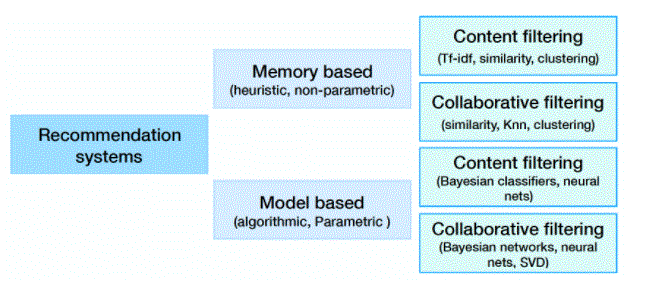


The above diagram provides a good description by categorising different methodologies for building a recommender system. Suppose someone has watched “Inception (2010)” and loved it! What can my recommender system suggest to them to watch next?
We could suggest different movies on the basis of the content similarity to the selected movie such as genres, cast and crew names, keywords and any other metadata from the movie. In that case I would be using an item-content filtering. I could also compare the user metadata such as age and gender to the other users and suggest items to the user that similar users have liked. In that case I would be using a user-content filtering. The movie-lens dataset used here does not contain any user content data. So in a first step we will be building an item-content (here a movie-content) filter.

### Memory-based content filtering

In memory-based methods we don’t have a model that learns from the data to predict, but rather we form a pre-computed matrix of similarities that can be predictive. The data sets we have used for an item content filtering are movies.csv and tags.csv. We collect all the tags given to each movie by various users, add the movie’s genre keywords and form a final data frame with a metadata column for each movie.

### Load in the datasets 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle
print("All libraries loaded successfully!")

All libraries loaded successfully!


### Read in the data:

In [3]:
#Load movies data

movies = pd.read_csv('movies.csv')
genome_scores = pd.read_csv('genome_scores.csv')
tags = pd.read_csv('tags.csv')
genome_tags = pd.read_csv('genome_tags.csv')

#Use ratings data to downsample tags data to only movies with ratings 
ratings = pd.read_csv('train.csv')
ratings = ratings.drop_duplicates('movieId')

In [6]:
movies.tail()
movies['genres'] = movies['genres'].str.replace('|',' ')

In [7]:
len(movies.movieId.unique())

62423

In [8]:
len(ratings.movieId.unique())

48213

### Filtering and cleaning

limit ratings to user ratings that have rated more that 10 movies -- 
Otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.

In [9]:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 10)

# list the movie titles that survive the filtering
movie_list_rating = ratings_f.movieId.unique().tolist()

By taking only users that have rated at least 10 movies, we have kept 43% of the original movie titles in the dataframe

In [10]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

42.801531486791724

And only 5% of the users...

In [12]:
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

5.424582284275578

In [13]:
# Filtering movies from the dataframe
movies = movies[movies.movieId.isin(movie_list_rating)]

In [14]:
movies.head(3)

,movieId,title,genres
12,13,Balto (1995),Adventure Animation Children
50,51,Guardian Angel (1994),Action Drama Thriller
73,74,Bed of Roses (1996),Drama Romance


#### Let's map the movie to id

In [16]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

#### Now we are going to drop the 'timestamp' because we don't need it 

In [17]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

#### Merge the movies and the tags data frame and create a metadata tag for each movie:

create a mixed dataframe of movies title, genres and all user tags given to each movie

In [18]:
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,13,Balto (1995),Adventure Animation Children,2287.0,Ei muista
1,13,Balto (1995),Adventure Animation Children,6550.0,alaska
2,13,Balto (1995),Adventure Animation Children,6550.0,bear attack


#### Now we create metadata from tags and genres 

In [19]:
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,13,Balto (1995),Ei muista alaska bear attack dog dog sled dog-...
1,51,Guardian Angel (1994),Action Drama Thriller
2,74,Bed of Roses (1996),predictable family relationships florist poor ...


#### Creating a content latent matrix from movie metadata:


#### tf-idf vectors and truncated SVD :

In [20]:
Final.head()

,movieId,title,genres,tag,metadata
0,13,Balto (1995),Adventure Animation Children,Ei muista alaska bear attack dog dog sled dog-...,Ei muista alaska bear attack dog dog sled dog-...
1,51,Guardian Angel (1994),Action Drama Thriller,,Action Drama Thriller
2,74,Bed of Roses (1996),Drama Romance,predictable family relationships florist poor ...,predictable family relationships florist poor ...
3,106,Nobody Loves Me (Keiner liebt mich) (1994),Comedy Drama,falling in love prophecy rich man single voodo...,falling in love prophecy rich man single voodo...
4,115,Happiness Is in the Field (Bonheur est dans le...,Comedy,best friend country identity swap twins woman ...,best friend country identity swap twins woman ...


In [21]:
ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


We will drop 'timestamp' because we don't need it

In [22]:
ratings.drop(['timestamp'], axis=1)

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0
...,...,...,...
9997490,84146,107912,3.0
9997689,72315,190143,2.5
9997995,131116,206347,3.0
9998418,85757,196867,3.5


Let's create a mixed dataframe of movies title, genres and all user tags given to each movie

In [23]:
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,13,Balto (1995),Adventure Animation Children,2287.0,Ei muista
1,13,Balto (1995),Adventure Animation Children,6550.0,alaska
2,13,Balto (1995),Adventure Animation Children,6550.0,bear attack


Create metadata from tags and genres

In [24]:
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,13,Balto (1995),Ei muista alaska bear attack dog dog sled dog-...
1,51,Guardian Angel (1994),Action Drama Thriller
2,74,Bed of Roses (1996),predictable family relationships florist poor ...


We then transform these metadata texts to vectors of features using Tf-idf transformer of scikit-learn package. Each movie will transform into a vector of the length ~ 19000! But we don’t really need such large feature vectors to describe movies. Truncated singular value decomposition (SVD) is a good tool to reduce dimensionality of our feature matrix especially when applied on Tf-idf vectors. As you can see from the explained variance graph below, with 200 latent components (reduction from ~19000) we can explain more than 50% of variance in the data which suffices for our purpose in this work. So we will keep a latent matrix of 200 components as opposed to 19074 which expedites our analysis greatly.
We name this latent matrix the content_latent and use this matrix a few steps later to find our top N similar movies to a given movie title. But let’s learn a bit about the ratings data.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(26718, 19074)


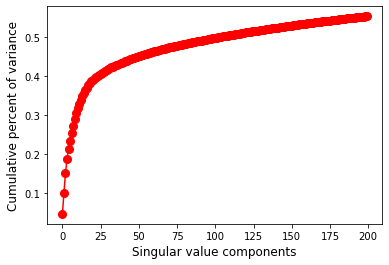

In [27]:
# Compress with SVD

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)

# plot var expalined to see what latent dimensions to usef
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [49]:
#number of latent dimensions to keep
n=200
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

Let's take a look at the new shape - reduced from 19 074 to just 200! 

In [41]:
latent_matrix.shape

(26718, 200)

In [42]:
ratings_f.head()

,userId,movieId,rating
26,89538,6538,3.5
30,50882,89745,5.0
32,157019,64983,4.0
53,97452,6998,3.5
57,95600,4195,4.0


### Memory-based collaborative filtering 

Aside from the movie metadata we have another valuable source of information at our exposure: the user rating data. Our recommender system can recommend a movie that is similar to “La Strada (1954)” on the basis of user ratings. In other words, what other movies have received similar ratings by other users? This would be an example of item-item collaborative filtering. It works something like “The users who liked this item also liked these other ones.” The data set of interest would be ratings.csv and we manipulate it to form items as vectors of input rates by the users. As there are many missing votes by users, we have imputed Nan(s) by 0 which would suffice for the purpose of our collaborative filtering.

In [43]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")

In [44]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [45]:
ratings_f2.head(3)

userId,450,541,548,653,847,997,1477,1503,1652,1977,...,160809,161542,161928,162047,162067,162235,162271,162358,162386,162516
movieId,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here we have movies as vectors of length ~711. Again as before we can apply a truncated SVD to this rating matrix and only keep the first 200 latent components which we will name latent matrix_2

In [46]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2,
                             index=Final.title.tolist())

Let's plot the variance explained to see what latent dimensions to use

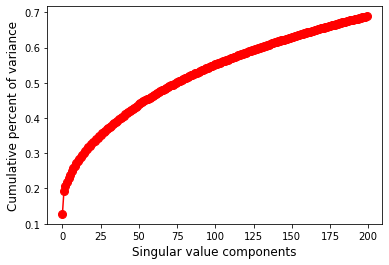

In [47]:
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

As can be seen from the above graph, with 200 latent components we can explain 70% of the variance!

The next step is to use a similarity measure and find the top N most similar movies to “La Strada (1954)” on the basis of each of these filtering methods we introduced. Cosine similarity is one of the similarity measures we can use. In the following, you will see how the similarity of an input movie title can be calculated with both content and collaborative latent matrices. We have also added a hybrid filter which is an average measure of similarity from both content and collaborative filtering standpoints. If we list the top 10 most similar movies to “La Strada (1954)” on the basis of the hybrid measure, you will see the following list in the data frame. It seems like the hybrid measure is predicting more reasonable titles than any of the other filters.

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Strada, La (1954)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Strada, La (1954)']).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Journey of Hope (Reise der Hoffnung) (1990),0.654396,0.150034,0.402215
Sundays and Cybele (Les dimanches de Ville d'Avray) (1962),0.644913,0.000007,0.322460
Black Narcissus (1947),0.586342,0.022642,0.304492
"Last Detail, The (1973)",0.557166,0.039932,0.298549
"Double Life, A (1947)",0.545258,0.133553,0.339405
Dancing Arabs (2014),0.540011,-0.167508,0.186252
"Defiant Ones, The (1958)",0.539445,0.025699,0.282572
"Touch of Class, A (1973)",0.531591,-0.068809,0.231391
Places in the Heart (1984),0.529405,0.024264,0.276835
Aarya 2 (2009),0.529236,-0.000906,0.264165


#### Model-based collaborative filtering

#### Implementation 


A SVD algorithm similar to the one described above has been implemented in Surprise library, which we will use here. 
We gain a root-mean-squared error (RMSE) accuracy of 0.8394 (the lower the better!) for our rating data, which does not sound bad at all. 

In [51]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_f[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.8394


0.8394343777830107

### Now let's read in our test set 

In [52]:
test = pd.read_csv('test.csv')
test.sample(5)

,userId,movieId
4152824,135026,59615
2404559,78064,1407
3821261,123942,2739
4532785,147316,2006
3078259,99782,5218


In [53]:
# this will take a while, be patient runnint it :)

def predict_rating(row):
    u = row["userId"]
    i = row["movieId"]
    return algorithm.estimate(u, i)

test = test.assign(rating=test.apply(predict_rating, axis=1))

In [54]:
test.sample(5)

,userId,movieId,rating
3669100,118832,1269,2.773398
4471193,145372,1614,2.932174
1365404,44249,5502,2.835402
4163894,135429,2720,2.903688
4866845,158109,94677,2.971404


#### Now we put the prediction in the submission format they require in Kaggle, they want the Id to be simply userId_movieId

In [55]:
test = test.assign(Id=test.userId.astype(str)+"_"+test.movieId.astype(str))
submission = test[["Id", "rating"]]
submission.to_csv("submission_rec.csv", index=None)

#### Next we use this trained model to predict ratings for the movies that a given user here e.g. with the id = 7010, has not rated yet. The top 10 highly rated movies can be recommended to user 7010 as you can see below.

In [57]:
def pred_user_rating(ui):
    if ui in ratings_f.userId.unique():
        ui_list = ratings_f[ratings_f.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None
    
user_id = 50882
pred_user_rating(user_id)

,ratings
movies,
Ken (1964),3.903333
Gargandi snilld (2005),3.898239
Katzelmacher (1969),3.895754
Great Guns (1941),3.883166
Doomed: The Untold Story of Roger Corman's the Fantastic Four (2015),3.881859
Studio 54 (2018),3.880372
Daisies (Sedmikrasky) (1966),3.874761
Til Death Do Us Part (2011),3.864789
Doug Stanhope: Deadbeat Hero (2004),3.861366


In [58]:
submission = pd.read_csv('submission_rec.csv')
submission.head()

,Id,rating
0,1_2011,2.259009
1,1_4144,2.397994
2,1_5767,2.198339
3,1_6711,2.357202
4,1_7318,2.263759
